In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib import ticker
from matplotlib.collections import PatchCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
import datetime
import os
import re
import pandas as pd
import shutil
import pycubicspline
import smtplib, ssl
import time
from scipy.stats import entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

from mpl_toolkits.basemap import Basemap
import matplotlib.image as mpimg

from glmtools.io.glm import GLMDataset

import haversine

from squeemtools.math import FCM
from squeemtools.other import EmailDone
import BetterMap as BM
import storm_centered_coords as scc

import warnings
warnings.filterwarnings("ignore")

#Turn off interactive plotting for pyplot
plt.ioff()

C:\Users\bvano\Anaconda3\envs\glmval\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
dorian_processed = xr.open_dataset('./Processed_Dorian.nc')
dp = dorian_processed.to_dataframe()
del dorian_processed

dorian_center = pd.read_csv('./ATL_19_5_Dorian_Cubic_Spline_Trackfile.csv')
dorian_center['Date'] = dorian_center['Date'].apply(pd.to_datetime)
dates = [pd.to_datetime(date) for date in dorian_center['Date'].values]

In [4]:
def apply_mapping(x,mapp):
    return mapp[x]

In [61]:
# Map boundaries
buffer = 7.5
shp_file = "./World_Countries__Generalized_-shp/World_Countries__Generalized_"
cmap = 'gist_ncar'
past_centers = None

for index,date in enumerate(dates):
    starttime = time.perf_counter()
    subset = dp[(dp['group_time_offset'] >= date) & (dp['group_time_offset'] < date + datetime.timedelta(minutes=10))].copy()
    center = dorian_center[dorian_center['Date'] == date]
    
    if len(subset) != 0:
        dbscan = DBSCAN(eps=.2,min_samples=2)
        subset['labels'] = dbscan.fit_predict(subset[['group_lon','group_lat']])
#         centers = subset.groupby('labels').mean()[['group_lon','group_lat']]
        
#         if past_centers is not None:
#             mapping = {-1:-1}
#             for new_label,new_loc in zip(centers.index,centers.values):
#                 dist = 100000
#                 closest = -2
#                 for label,loc in zip(past_centers.index,past_centers.values):
#                     if label == -1 or new_label == -1:
#                         continue

#                     d = np.linalg.norm(new_loc - loc)
#                     if d <= dist:
#                         dist = d
#                         closest = label

#                 mapping[new_label] = closest

#             subset['labels'] = subset['labels'].apply(apply_mapping,mapp=mapping)
#     else:
#         centers = None
    
    edges = (center['Long'].values[0] - buffer, center['Long'].values[0] + buffer, center['Lat'].values[0] - buffer, center['Lat'].values[0] + buffer)
    
    xlim = np.append(np.arange(edges[0],edges[1],step=2.5),edges[1])
    ylim = np.append(np.arange(edges[2],edges[3],step=2.5),edges[3])
    
    fig, ax = plt.subplots(figsize=(30,15))
    m = Basemap()
    m.readshapefile(shp_file, 'world',linewidth=1)
    patches = [Polygon(np.array(shape), True) for info, shape in zip(m.world_info, m.world)]
    ax.add_collection(PatchCollection(patches, facecolor= '#838688', edgecolor='k', linewidths=1., zorder=2))
    ax.add_patch(mpl.patches.Rectangle((-180,-89),360,180,color='#a6cae0'))
    ax.add_patch(mpl.patches.Rectangle((-179.9,-89.9),360,2,color='#838688',zorder=3))
    
    if len(subset) != 0:
        plt.scatter(subset['group_lon'],subset['group_lat'],c=subset['labels'],cmap=cmap,zorder=5)
        #m.scatter(subset['group_lon'],subset['group_lat'],c=subset['labels'],cmap=cmap)
    #m.plot(subset['group_lon'],subset['group_lat'],linestyle='none', marker="o", markersize=5, alpha=1, c="yellow", markeredgecolor="black", markeredgewidth=1,zorder=5)
    m.plot(center['Long'],center['Lat'],linestyle='none', marker="o", markersize=10, alpha=1, c="red", markeredgecolor="black", markeredgewidth=1,zorder=5)
    
    plt.title(f"Hurricane Dorian : {date}")
    ax.set_xticks(xlim)
    ax.set_yticks(ylim)
    ax.set_xlim(edges[0],edges[1])
    ax.set_ylim(edges[2],edges[3])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    
    plt.savefig(f"./Dorian_Images_2/{index}",bbox_inches='tight',pad_inches=.4) 
    plt.close('all')
    
    if centers is not None:
        past_centers = centers.copy()
    else:
        past_centers = None
    
    taken = time.perf_counter() - starttime
    print(f"Percent Done: {(index + 1) / len(dates) * 100 : .2f}%\tTime taken: {taken : .2f} seconds\tEst time remaining: {datetime.timedelta(seconds=(len(dates) - (index + 1)) * taken)} {len(subset)}",end='\r')

In [6]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [91]:
def run_entropy_test(eps,minpt,plot=True):
    shp_file = "./World_Countries__Generalized_-shp/World_Countries__Generalized_"
    cmap = 'gist_ncar'
    buffer = 7.5

    # Get the data and run dbscan
    date = pd.to_datetime("2019-09-01 20:00:00")
    subset = dp[(dp['group_time_offset'] >= date) & (dp['group_time_offset'] < date + datetime.timedelta(minutes=10))].copy()
    dbscan = DBSCAN(eps=eps,min_samples=minpt)
    subset['labels'] = dbscan.fit_predict(subset[['group_lon','group_lat']])
    centers = subset.groupby('labels').mean()[['group_lon','group_lat']]
    center = dorian_center[dorian_center['Date'] == date]
    labels = centers.index.unique()

    # Calculate distances between centers
    avg_dists = []
    for label in labels:
        if label == -1:
            continue

        pts = subset[subset['labels'] == label][['group_lon','group_lat']].values
        pt = centers.loc[label].values
        dists = np.array([np.linalg.norm(p - pt) for p in pts])
        avg_dists.append(dists.mean())

    if plot:
        # Get the colors
        normalizer = mpl.colors.Normalize(labels.min(),labels.max())
        colors = [plt.cm.gist_ncar(normalizer(label)) for label in subset['labels'].values]
        darker_colors = [adjust_lightness(color, .2) for color in colors]

        # Setup the map
        fig, ax = plt.subplots(figsize=(30,15))
        m = Basemap()
        m.readshapefile(shp_file, 'world',linewidth=1)
        patches = [Polygon(np.array(shape), True) for info, shape in zip(m.world_info, m.world)]
        ax.add_collection(PatchCollection(patches, facecolor= '#838688', edgecolor='k', linewidths=1., zorder=2))
        ax.add_patch(mpl.patches.Rectangle((-180,-89),360,180,color='#a6cae0'))
        ax.add_patch(mpl.patches.Rectangle((-179.9,-89.9),360,2,color='#838688',zorder=3))
        plt.title(f"Hurricane Dorian : {date}\t{eps}_{minpt}")
        edges = (center['Long'].values[0] - buffer, center['Long'].values[0] + buffer, center['Lat'].values[0] - buffer, center['Lat'].values[0] + buffer)
        xlim = np.append(np.arange(edges[0],edges[1],step=2.5),edges[1])
        ylim = np.append(np.arange(edges[2],edges[3],step=2.5),edges[3])
        ax.set_xticks(xlim)
        ax.set_yticks(ylim)
        ax.set_xlim(edges[0],edges[1])
        ax.set_ylim(edges[2],edges[3])
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

        # Actually plot the data
        m.plot(center['Long'],center['Lat'],linestyle='none', marker="o", markersize=10, alpha=1, c="red", markeredgecolor="black", markeredgewidth=1,zorder=5)
        plt.scatter(subset['group_lon'],subset['group_lat'],c=colors,cmap=cmap,zorder=5,edgecolors=darker_colors)
        plt.savefig(f"./dbscan_testing/{eps}_{minpt}.png",bbox_inches='tight',pad_inches=.4)
    return np.mean(avg_dists)

In [93]:
domain = np.arange(.05,.4,.01)
domain2 = range(2,10)

[[run_entropy_test(u,v) for v in domain2] for u in domain]

[[0.033401605,
  0.036997795,
  0.03886103,
  0.03786529,
  0.038145024,
  0.039420675,
  0.038677145,
  0.040044427],
 [0.036427006,
  0.039539747,
  0.042207297,
  0.04220138,
  0.04289342,
  0.04502908,
  0.045867976,
  0.046496417],
 [0.04060157,
  0.043872423,
  0.04721628,
  0.04721628,
  0.047095984,
  0.048601355,
  0.048813142,
  0.050874732],
 [0.04709605,
  0.04854385,
  0.052119937,
  0.052119937,
  0.0538776,
  0.053923592,
  0.054398865,
  0.056085728],
 [0.05084617,
  0.05111136,
  0.053478505,
  0.053478505,
  0.054371808,
  0.05520091,
  0.055655748,
  0.057430122],
 [0.054410484,
  0.05476623,
  0.057278764,
  0.057271924,
  0.05839772,
  0.059383053,
  0.060024753,
  0.060883418],
 [0.05726093,
  0.057685178,
  0.060545642,
  0.06053852,
  0.060759213,
  0.0618173,
  0.06252739,
  0.063428275],
 [0.058825105,
  0.059297606,
  0.062422648,
  0.062422648,
  0.06269503,
  0.063837424,
  0.0646403,
  0.06567019],
 [0.05888083,
  0.059354443,
  0.062484436,
  0.062484436,

In [49]:
past_centers = centers.copy()

date = pd.to_datetime("2019-09-01 20:10:00")
subset = dp[(dp['group_time_offset'] >= date) & (dp['group_time_offset'] < date + datetime.timedelta(minutes=10))].copy()
dbscan = DBSCAN(eps=.2,min_samples=2)
subset['labels'] = dbscan.fit_predict(subset[['group_lon','group_lat']])
# New centers
centers = subset.groupby('labels').mean()[['group_lon','group_lat']]

mapping = {-1:-1}
for new_label,new_loc in zip(centers.index,centers.values):
    dist = 100000
    closest = -2
    for label,loc in zip(past_centers.index,past_centers.values):
        if label == -1 or new_label == -1:
            continue
            
        d = np.linalg.norm(new_loc - loc)
        if d <= dist:
            dist = d
            closest = label
        
    mapping[new_label] = closest
    
subset['labels'] = subset['labels'].apply(apply_mapping,mapp=mapping)

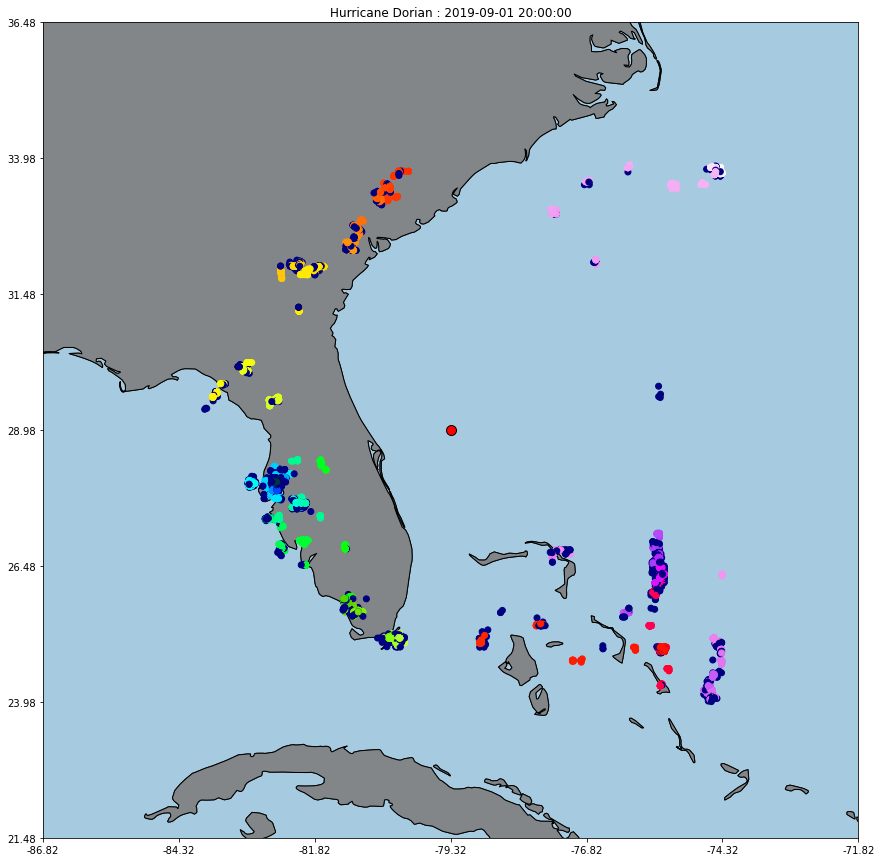

In [23]:
shp_file = "./World_Countries__Generalized_-shp/World_Countries__Generalized_"
cmap = 'gist_ncar'
buffer = 7.5

# Get the data and run dbscan
date = pd.to_datetime("2019-09-01 20:00:00")
subset = dp[(dp['group_time_offset'] >= date) & (dp['group_time_offset'] < date + datetime.timedelta(minutes=10))].copy()
optics = OPTICS(max_eps=5)
subset['labels'] = optics.fit_predict(subset[['group_lon','group_lat']])
centers = subset.groupby('labels').mean()[['group_lon','group_lat']]
center = dorian_center[dorian_center['Date'] == date]
labels = centers.index.unique()

# Setup the map
fig, ax = plt.subplots(figsize=(30,15))
m = Basemap()
m.readshapefile(shp_file, 'world',linewidth=1)
patches = [Polygon(np.array(shape), True) for info, shape in zip(m.world_info, m.world)]
ax.add_collection(PatchCollection(patches, facecolor= '#838688', edgecolor='k', linewidths=1., zorder=2))
ax.add_patch(mpl.patches.Rectangle((-180,-89),360,180,color='#a6cae0'))
ax.add_patch(mpl.patches.Rectangle((-179.9,-89.9),360,2,color='#838688',zorder=3))
plt.title(f"Hurricane Dorian : {date}")
edges = (center['Long'].values[0] - buffer, center['Long'].values[0] + buffer, center['Lat'].values[0] - buffer, center['Lat'].values[0] + buffer)
xlim = np.append(np.arange(edges[0],edges[1],step=2.5),edges[1])
ylim = np.append(np.arange(edges[2],edges[3],step=2.5),edges[3])
ax.set_xticks(xlim)
ax.set_yticks(ylim)
ax.set_xlim(edges[0],edges[1])
ax.set_ylim(edges[2],edges[3])
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Actually plot the data
m.plot(center['Long'],center['Lat'],linestyle='none', marker="o", markersize=10, alpha=1, c="red", markeredgecolor="black", markeredgewidth=1,zorder=5)
plt.scatter(subset['group_lon'],subset['group_lat'],c=optics.labels_,cmap=cmap,zorder=5)
plt.show()